# <center>Bike Share Query Project</center>

Adam Yang - MIDS w205 Project 1

### Problem Statement
- You're a data scientist at Ford GoBike (https://www.fordgobike.com/), the company running Bay Area Bikeshare. You are trying to increase ridership, and you want to offer deals through the mobile app to do so. What deals do you offer though? Currently, your company has three options: a flat price for a single one-way trip, a day pass that allows unlimited 30-minute rides for 24 hours and an annual (monthly) membership.
- Through this project, you will answer these questions:
  * What are the 5 most popular trips that you would call "commuter trips"?
  * What are your recommendations for offers (justify based on your findings)?

### Examining the Data Set and Contextualizing the Problem Statement
My goal is to provide Ford GoBike with recommendations regarding the type of deals they can offer in order to increase ridership. However, before I dig deep into the specific recommendations, it would be beneficial to take a broad look at the data to get a sense of how the riders are behaving.

The first thing I wanted to do is to get a sense of when people are using these bikes.

In [1]:
# On what days of the week are these bikes mostly uses? Are they used by Customers or Subscribers?
! bq query --use_legacy_sql=false --format=csv 'SELECT EXTRACT(DAYOFWEEK FROM start_date) AS dow, COUNT(trip_id) as count, subscriber_type as sub_type FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY dow, sub_type ORDER BY dow' > dowtrend.csv

Waiting on bqjob_r4fc6c4a8c10181ce_000001641292c8bb_1 ... (0s) Current status: DONE   

Query Code:

```SQL
bq query --use_legacy_sql=false '
  SELECT
    EXTRACT(DAYOFWEEK FROM start_date) AS dow,
    COUNT(trip_id) as count, 
    subscriber_type as sub_type
  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
  GROUP BY dow, sub_type
  ORDER BY dow '
```

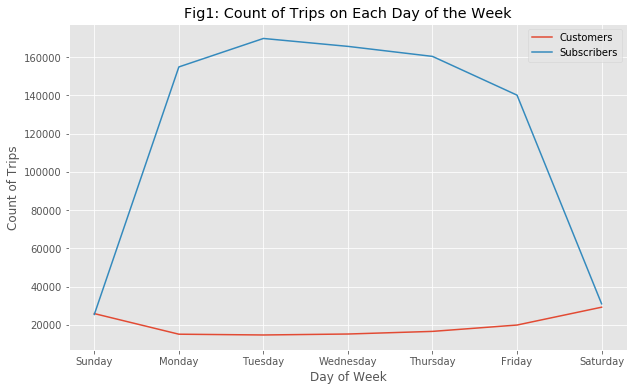

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import datetime
dowtrend = pd.read_csv('dowtrend.csv')
dow = {"dow": ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]}
df = pd.DataFrame(dow)
cust = []
sub = []
for i in dowtrend.index:
    if dowtrend.sub_type[i] == "Customer":
        cust.append(dowtrend["count"][i])
    elif dowtrend.sub_type[i] == "Subscriber":
        sub.append(dowtrend["count"][i])
df["cust_count"] = cust
df["sub_count"] = sub
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1 = plt.plot(df.dow, df.cust_count)
ax1 = plt.plot(df.dow, df.sub_count)
plt.xlabel("Day of Week")
plt.ylabel("Count of Trips")
plt.title("Fig1: Count of Trips on Each Day of the Week")
plt.legend(["Customers", "Subscribers"])

In Fig1 shown above, we can see that the vast majority of the trips are taken from Monday to Friday by subscribers. On the weekends, the number of trips taken by subscribers drop down to almost equivalent levels as customer trips. In contrast, the number of customer trips on the weekends are actually higher than the number of trips on the weekdays. From Fig1, I drew the inference that most leisurely riders are under the customer package while most riders who use these bikes to commute to work, are under the subscriber package. Furthermore, the usage of these bikes for commuting purposes far outweigh the leisurely usage of these bikes. However, to gain more confidence in this assumption, we should look at the number of trips taken at each hour of the day.

In [3]:
# What hours are the most bikes being checked out on weekdays?
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT MIN(EXTRACT(HOUR FROM start_date)) as hour_num, COUNT (trip_ID) as count FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(DAYOFWEEK FROM start_date) > 1 AND EXTRACT(DAYOFWEEK FROM start_date) <= 6 GROUP BY EXTRACT(HOUR FROM start_date) ORDER BY hour_num' > weekdaybyhour.csv

Waiting on bqjob_r42a2f085cd5a8514_00000164129301f3_1 ... (0s) Current status: DONE   

Query Code:
```SQL
bq query --use_legacy_sql=FALSE '
    SELECT MIN(EXTRACT(HOUR FROM start_date)) as hour_num, COUNT (trip_ID) as count
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    WHERE EXTRACT(DAYOFWEEK FROM start_date) > 1
    AND EXTRACT(DAYOFWEEK FROM start_date) <= 6
    GROUP BY EXTRACT(HOUR FROM start_date)
    ORDER BY hour_num'
```

In [4]:
# What hours are the most bikes being checked out on weekends?
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT MIN(EXTRACT(HOUR FROM start_date)) as hour_num, COUNT (trip_ID) as count FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(DAYOFWEEK FROM start_date) = 0 OR EXTRACT(DAYOFWEEK FROM start_date) = 7 GROUP BY EXTRACT(HOUR FROM start_date) ORDER BY hour_num' > weekendbyhour.csv

Waiting on bqjob_r5e4d441816c82fd7_0000016412931658_1 ... (0s) Current status: DONE   

Query Code:
```SQL
bq query --use_legacy_sql=FALSE '
    SELECT MIN(EXTRACT(HOUR FROM start_date)) as hour_num, COUNT (trip_ID) as count
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    WHERE EXTRACT(DAYOFWEEK FROM start_date) = 0
    OR EXTRACT(DAYOFWEEK FROM start_date) = 7
    GROUP BY EXTRACT(HOUR FROM start_date)
    ORDER BY hour_num'
```

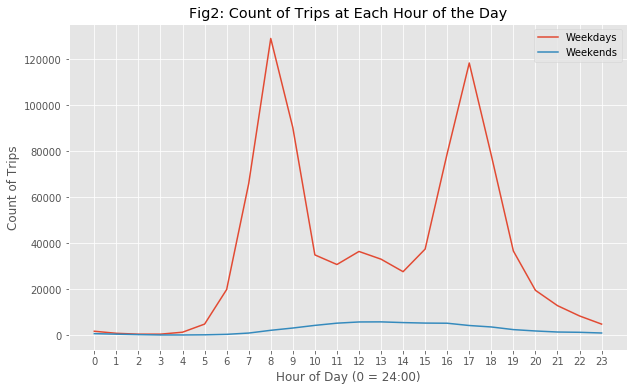

In [5]:
wday = pd.read_csv('weekdaybyhour.csv')
wend = pd.read_csv('weekendbyhour.csv')
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1 = plt.plot(wday.hour_num, wday["count"])
ax1 = plt.plot(wend.hour_num, wend["count"])
plt.xticks(range(0,24))
plt.xlabel("Hour of Day (0 = 24:00)")
plt.ylabel("Count of Trips")
plt.title("Fig2: Count of Trips at Each Hour of the Day")
plt.legend(["Weekdays", "Weekends"])

Fig2 as shown above, presents the number of trips taken at each hour of the day for weekdays and weekends. This graph shows two sharp peaks at 8 am and 5pm on the weekdays, while the number of trips on weekends peak at around noon. With Fig1 and Fig2 combined, I feel pretty confident in my assumption that most riders using these bikes to commute are under the subscriber package and that by far the most popular usage for these bikes are for the purpose of commuting to work.

#### Defining Commuter Trips

With this information shown in Fig2, we can also define the term ***commuter trips***. According to MTA train rules, commuting hours are between 6am to 10am and 4pm to 8pm. Judging by Fig2, I think the hours 6am to 10am are a good representation of when people are traveling to work. However, the hours of 3pm to 7pm are a better representation of when people are traveling home from work. Therefore, from here on out, ***commuter trips*** will be defined as trips taken within the hours of 6am to 10am and 3pm to 7pm on a weekday.

#### What Percentage of Bike Trips are Used for Commuting Purposes?

As an extra layer of insight, I would like to know what percentage of the total trips can be classified as a commuter trip.

In [6]:
# How many total trips are there?
! bq query --use_legacy_sql=FALSE 'SELECT COUNT(DISTINCT(trip_id)) FROM `bigquery-public-data.san_francisco.bikeshare_trips`'

Waiting on bqjob_r69174182c3d7aa97_0000016412935278_1 ... (0s) Current status: DONE   
+--------+
|  f0_   |
+--------+
| 983648 |
+--------+


Query Code:
```SQL
bq query --use_legacy_sql=FALSE '
  SELECT COUNT(DISTINCT(trip_id))
  FROM `bigquery-public-data.san_francisco.bikeshare_trips`'
```

In [7]:
# How many trips can be called "commuter trips" going to work? (6am - 10am Weekdays)
! bq query --use_legacy_sql=FALSE --format=pretty 'SELECT COUNT(start_date) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(DAYOFWEEK FROM start_date) > 1 AND EXTRACT(DAYOFWEEK FROM start_date) <= 6 AND EXTRACT(TIME FROM start_date) >= "06:00:00.000" AND EXTRACT(TIME FROM start_date) <= "10:00:00.000"'

Waiting on bqjob_r58704bf7b399f231_00000164129366c9_1 ... (0s) Current status: DONE   
+--------+
|  f0_   |
+--------+
| 305724 |
+--------+


Query Code:
```SQL
bq query --use_legacy_sql=false '
    SELECT COUNT(start_date)
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    WHERE EXTRACT(DAYOFWEEK FROM start_date) > 1
    AND EXTRACT(DAYOFWEEK FROM start_date) <= 6
    AND EXTRACT(TIME FROM start_date) >= "06:00:00.000"
    AND EXTRACT(TIME FROM start_date) <= "10:00:00.000"'
```

In [8]:
# How many trips can be called "commuter trips" returning from work? (3pm - 7pm Weekdays)
! bq query --use_legacy_sql=FALSE 'SELECT COUNT(start_date)  FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE EXTRACT(DAYOFWEEK FROM start_date) > 1 AND EXTRACT(DAYOFWEEK FROM start_date) <= 6 AND EXTRACT(TIME FROM start_date) >= "15:00:00.000" AND EXTRACT(TIME FROM start_date) <= "19:00:00.000"'

Waiting on bqjob_r21ea8621552cb4b1_000001641293762d_1 ... (0s) Current status: DONE   
+--------+
|  f0_   |
+--------+
| 313718 |
+--------+


Query Code:
```SQL
bq query --use_legacy_sql=FALSE '
    SELECT COUNT(start_date) 
    FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
    WHERE EXTRACT(DAYOFWEEK FROM start_date) > 1 
    AND EXTRACT(DAYOFWEEK FROM start_date) <= 6 
    AND EXTRACT(TIME FROM start_date) >= "15:00:00.000" 
    AND EXTRACT(TIME FROM start_date) <= "19:00:00.000"'
```

From the SQL queries above, we see that there are 983648 total trips in the data set and 305724 are commuter trips to work while 313718 are commuter trips from work. With these numbers, we can calculate that around 31% of the trips are taken between 6am and 10am and around 32% of the trips are taken between 3pm and 7pm. This adds up to a total of 63% of the trips classified as commuter trips, while 37% of the total trips are not commuter trips.

#### Analyzing the Available Payment Options

We are told that Ford GoBike has three available payment options: a flat price for a single one-way trip, a day pass that allows unlimited 30-minute rides for 24 hours, and an annual (paid monthly) membership. It might be beneficial to get some insight about these three payment options. Based on the information given, I will assume that the annual membership riders are labeled as *subscribers*, while riders using the other two payment options are labeled as *customers*. Therefore, it would be beneficial to get a count of each of the two groups.

In [9]:
# How many trips are taken by subscribers?
! bq query --use_legacy_sql=FALSE 'SELECT COUNT(trip_id) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Subscriber"'

Waiting on bqjob_r6d1eff66362882b5_0000016412938e54_1 ... (0s) Current status: DONE   
+--------+
|  f0_   |
+--------+
| 846839 |
+--------+


Query Code:
```SQL
! bq query --use_legacy_sql=FALSE '
  SELECT COUNT(trip_id)
  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
  WHERE subscriber_type = "Subscriber"'
```

In [10]:
# How many trips are taken by customers?
! bq query --use_legacy_sql=FALSE 'SELECT COUNT(trip_id) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Customer"'

Waiting on bqjob_r6ddf720fae953d18_0000016412939ec7_1 ... (0s) Current status: DONE   
+--------+
|  f0_   |
+--------+
| 136809 |
+--------+


Query Code:
```SQL
! bq query --use_legacy_sql=FALSE '
  SELECT COUNT(trip_id)
  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
  WHERE subscriber_type = "Customer"'
```

The queries above show that 846839 trips are taken by subscribers, while 136809 trips are taken by customers. This means that 86% of the trips are taken by subscribers and 14% of the trips are taken by customers. Now we can look at what percentage of the subscriber trips are considered commuter trips.

In [11]:
# How many of the "commuter trips" are from people who are subscribers (annual or 30-day memberships)?
! bq query --use_legacy_sql=FALSE 'SELECT COUNT(subscriber_type) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE (EXTRACT(DAYOFWEEK FROM start_date) > 1 AND EXTRACT(DAYOFWEEK FROM start_date) <= 6) AND ((EXTRACT(TIME FROM start_date) >= "06:00:00.000" AND EXTRACT(TIME FROM start_date) <= "10:00:00.000") OR (EXTRACT(TIME FROM start_date) >= "15:00:00.000" AND EXTRACT(TIME FROM start_date) <= "19:00:00.000")) AND subscriber_type = "Subscriber"'

Waiting on bqjob_r187773dd4db040c6_000001641293b057_1 ... (0s) Current status: DONE   
+--------+
|  f0_   |
+--------+
| 580742 |
+--------+


Query Code:
```SQL
bq query --use_legacy_sql=FALSE '
    SELECT COUNT(subscriber_type)
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    WHERE (EXTRACT(DAYOFWEEK FROM start_date) > 1
    AND EXTRACT(DAYOFWEEK FROM start_date) <= 6)
    AND ((EXTRACT(TIME FROM start_date) >= "06:00:00.000"
    AND EXTRACT(TIME FROM start_date) <= "10:00:00.000")
    OR (EXTRACT(TIME FROM start_date) >= "15:00:00.000"
    AND EXTRACT(TIME FROM start_date) <= "19:00:00.000"))
    AND subscriber_type = "Subscriber"'
```

The query above concluded that 580742 out of the 846839 subscriber trips are commuter trips. This means that approximately 69% of the trips taken by annual subscribers are used to get to and from work. It's been clear that the majority of the trips taken are by subscribers. Now we also know that the majority of the trips taken by subscribers are during commuting hours. However, 31% of the trips taken by subscribers are not during commuting hours which means there is still a lot of trips taken for other purposes.

But what about the other two payment methods? First, let’s take a look at the riders paying for one-way trips. We will define these trips as having a different start station and end station names. Furthermore, we only care about the customers because the subscribers are using the annual payment plan.

In [12]:
# How many trips are the start station name and the end station names differet (one way trips)?
# We only care about the customers because the subscribers are using a different payment method.
! bq query --use_legacy_sql=FALSE 'SELECT COUNT(trip_id) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Customer" AND start_station_name != end_station_name'

Waiting on bqjob_r21fd2bff11328813_000001641293c3cd_1 ... (0s) Current status: DONE   
+--------+
|  f0_   |
+--------+
| 114656 |
+--------+


Query Code:
```SQL
bq query --use_legacy_sql=FALSE '
    SELECT COUNT(trip_id)
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    WHERE subscriber_type = "Customer"
    AND start_station_name != end_station_name'
```

In [13]:
# How many of the "commuter trips" are the start station name and the end station names differet (one way trips)?
# We only care about the customers because the subscribers are using a different payment method.
! bq query --use_legacy_sql=FALSE 'SELECT COUNT(trip_id) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE (EXTRACT(DAYOFWEEK FROM start_date) > 1 AND EXTRACT(DAYOFWEEK FROM start_date) <= 6) AND ((EXTRACT(TIME FROM start_date) >= "06:00:00.000" AND EXTRACT(TIME FROM start_date) <= "10:00:00.000") OR (EXTRACT(TIME FROM start_date) >= "15:00:00.000" AND EXTRACT(TIME FROM start_date) <= "19:00:00.000")) AND subscriber_type = "Customer" AND start_station_name != end_station_name'

Waiting on bqjob_r61a72c40a3d4916c_000001641293d578_1 ... (0s) Current status: DONE   
+-------+
|  f0_  |
+-------+
| 33907 |
+-------+


Query Code:
```SQL
bq query --use_legacy_sql=FALSE '
    SELECT COUNT(trip_id)
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    WHERE (EXTRACT(DAYOFWEEK FROM start_date) > 1
    AND EXTRACT(DAYOFWEEK FROM start_date) <= 6)
    AND ((EXTRACT(TIME FROM start_date) >= "06:00:00.000"
    AND EXTRACT(TIME FROM start_date) <= "10:00:00.000")
    OR (EXTRACT(TIME FROM start_date) >= "15:00:00.000"
    AND EXTRACT(TIME FROM start_date) <= "19:00:00.000"))
    AND subscriber_type = "Customer"
    AND start_station_name != end_station_name'
```

Based on the queries above, we see that 114656 out of 136809 total customer trips are one-way trips (84%). Furthermore, 33907 of the 114656 one-way trips are used during commuting hours (30%). This tells me that 70% of the people using this payment plan are not riding during commuting hours. This makes sense because it seems that most of the riders using these bikes during commuting hours are using the annual payment plan.

Finally, let's take a look at the last payment plan, which is a day pass that allows unlimited 30-minute rides. In this case, we will look at all customer trips that are 30 minutes and less. Like before, we only care about customer trips because subscriber trips are using the annual payment plan according to our assumptions.

In [14]:
# How many customer trips are 30 minutes and less?
# We only care about customer trips because subscribers are using a different payment method.
! bq query --use_legacy_sql=FALSE 'SELECT COUNT(start_date) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Customer" AND duration_sec <= 1800'

Waiting on bqjob_r4a4cdab2b5848627_000001641293ec05_1 ... (0s) Current status: DONE   
+-------+
|  f0_  |
+-------+
| 94796 |
+-------+


Query Code:
```SQL
bq query --use_legacy_sql=FALSE '
    SELECT COUNT(start_date)
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    WHERE AND subscriber_type = "Customer"
    AND duration_sec <= 1800'
```

In [15]:
# How many "commuter trips" are 30 minutes and less?
# We only care about customer trips because subscribers are using a different payment method.
! bq query --use_legacy_sql=FALSE 'SELECT COUNT(start_date) FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE (EXTRACT(DAYOFWEEK FROM start_date) > 1 AND EXTRACT(DAYOFWEEK FROM start_date) <= 6) AND ((EXTRACT(TIME FROM start_date) >= "06:00:00.000" AND EXTRACT(TIME FROM start_date) <= "10:00:00.000") OR (EXTRACT(TIME FROM start_date) >= "15:00:00.000" AND EXTRACT(TIME FROM start_date) <= "19:00:00.000")) AND subscriber_type = "Customer" AND duration_sec <= 1800'

Waiting on bqjob_r7e164a2ce26a038_000001641293ffc0_1 ... (0s) Current status: DONE   
+-------+
|  f0_  |
+-------+
| 29576 |
+-------+


Query Code:
```SQL
bq query --use_legacy_sql=FALSE '
    SELECT COUNT(start_date)
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    WHERE (EXTRACT(DAYOFWEEK FROM start_date) > 1
    AND EXTRACT(DAYOFWEEK FROM start_date) <= 6)
    AND ((EXTRACT(TIME FROM start_date) >= "06:00:00.000"
    AND EXTRACT(TIME FROM start_date) <= "10:00:00.000")
    OR (EXTRACT(TIME FROM start_date) >= "15:00:00.000"
    AND EXTRACT(TIME FROM start_date) <= "19:00:00.000"))
    AND subscriber_type = "Customer"
    AND duration_sec <= 1800'
```

The queries above show that 94796 out of 136809 customers are taking trips less than 30 minutes (69%). Furthermore, 29576 out of the 94790 30-minute trips are taken during commuting hours (31%). Similar to the one-way trip payment plan, it seems like most of the people using this payment plan are not riding during commuting hours. Again, this makes sense because it seems that most of the riders using these bikes during commuting hours are using the annual payment plan.

### What are the 5 most popular trips that you would call "commuter trips"?

The way I am interpreting this question is, "what are the 5 most popular trips taken from point A to point B during commuting hours?"

In [16]:
! bq query --use_legacy_sql=FALSE 'SELECT COUNT(trip_id) AS trip_count, start_station_name, end_station_name FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE (EXTRACT(DAYOFWEEK FROM start_date) > 1 AND EXTRACT(DAYOFWEEK FROM start_date) <= 6) AND ((EXTRACT(TIME FROM start_date) >= "06:00:00.000" AND EXTRACT(TIME FROM start_date) <= "10:00:00.000") OR (EXTRACT(TIME FROM start_date) >= "15:00:00.000" AND EXTRACT(TIME FROM start_date) <= "19:00:00.000")) GROUP BY start_station_name, end_station_name ORDER BY trip_count DESC LIMIT 5'

Waiting on bqjob_r22e43c0335e2cf4_000001641294211b_1 ... (0s) Current status: DONE   
+------------+-----------------------------------------------+------------------------------------------+
| trip_count |              start_station_name               |             end_station_name             |
+------------+-----------------------------------------------+------------------------------------------+
|       5905 | 2nd at Townsend                               | Harry Bridges Plaza (Ferry Building)     |
|       5550 | Embarcadero at Folsom                         | San Francisco Caltrain (Townsend at 4th) |
|       5488 | Harry Bridges Plaza (Ferry Building)          | 2nd at Townsend                          |
|       5412 | San Francisco Caltrain 2 (330 Townsend)       | Townsend at 7th                          |
|       5304 | Temporary Transbay Terminal (Howard at Beale) | San Francisco Caltrain (Townsend at 4th) |
+------------+-----------------------------------------------+----

Query Code:
```SQL
bq query --use_legacy_sql=FALSE '
  SELECT COUNT(trip_id) AS trip_count, start_station_name, end_station_name
  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
  WHERE (EXTRACT(DAYOFWEEK FROM start_date) > 1
  AND EXTRACT(DAYOFWEEK FROM start_date) <= 6)
  AND ((EXTRACT(TIME FROM start_date) >= "06:00:00.000"
  AND EXTRACT(TIME FROM start_date) <= "10:00:00.000")
  OR (EXTRACT(TIME FROM start_date) >= "15:00:00.000"
  AND EXTRACT(TIME FROM start_date) <= "19:00:00.000"))
  GROUP BY start_station_name, end_station_name
  ORDER BY trip_count DESC
  LIMIT 5
```

The query above shows the 5 most popular commuter trips. I see that number 1 is from 2nd and Townsend to Harry Bridges Plaza (Ferry Building) and number 3 is the opposite direction. Perhaps many people are biking to the ferry in order to get to work somewhere else, or taking the ferry into San Francisco and then biking to work.

### Recommendations for Offers

There are 2 separate approaches towards offering deals to increase ridership. The first is to target the most popular instances where people use the bikes. From what we found in Fig1 and Fig2, these are subscribers who are paying an annual fee during commuting hours on weekdays. Maybe implementing offers towards this group of people would encourage others who are on the fence about biking to work to start doing so. The second approach is to target the cases where the bikes are used less often in order to incentivize people to start riding.

In terms of the first approach, we know that our most common riders are paying for the annual subscription based on Fig1. According to https://www.fordgobike.com/pricing, you can choose to do a monthly payment of \$15 a month, or you can do a one-time payment of \$149 for a year long subscription (saves \$31). I think a good way to get people to start these monthly payments is to offer a one-month free trial to new riders. This can potentially incentivize more riders to consider subscribing to the monthly or annual payment. Furthermore, Fig2 suggests that most of the trips are taken to get to and from work. According to https://www.fordgobike.com/pricing, there are corporate memberships available if your company is a partner to Ford GoBike. To take this a step further, Ford GoBike might extend the partnership with these comapanies and offer healthcare or carbon emission incentives to the employees who use these bikes. Maybe the employee can accumulate points depending on how many miles they ride and then exchange those points for commodities. I think there are riders who only ride to work a few days a year, so they would rather not go for the annual subscription. I think the two offers mentioned might convince these riders to ride to work more often and perhaps switch to an annual subscription. Finally, the current monthly/annual bike trip plan offers unlimited 45-minute trips. If you go over 45 minutes, you would have to pay extra. Now, it might be interesting to see if we can offer differnt types of subscriptions based on trip length.

In [17]:
# During commute hours, what bucket of trip lengths (15 min, 30 min, 45 min, 60 min, over 60 min) has the most number of trips?
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT t.time_range, COUNT(*) as count FROM( SELECT CASE WHEN duration_sec between 0 AND 900 THEN "15 mins" WHEN duration_sec between 900 AND 1800 THEN "30 mins" WHEN duration_sec between 1800 AND 2700 THEN "45 mins" WHEN duration_sec between 2700 AND 3600 THEN "60 mins" ELSE "60 mins plus" end as time_range FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE (EXTRACT(DAYOFWEEK FROM start_date) > 1 AND EXTRACT(DAYOFWEEK FROM start_date) <= 6) AND ((EXTRACT(TIME FROM start_date) >= "06:00:00.000" AND EXTRACT(TIME FROM start_date) <= "10:00:00.000") OR (EXTRACT(TIME FROM start_date) >= "15:00:00.000" AND EXTRACT(TIME FROM start_date) <= "19:00:00.000"))) t GROUP BY t.time_range ORDER BY time_range' > timebuckets.csv


Waiting on bqjob_r5f4d91dd48f7d8ab_0000016412944183_1 ... (0s) Current status: DONE   

Query Code:
```SQL
bq query --use_legacy_sql=FALSE '
    SELECT t.time_range, COUNT(*) as count
    FROM(
        SELECT CASE
            WHEN duration_sec between 0 AND 900 THEN "15 mins"
            WHEN duration_sec between 900 AND 1800 THEN "30 mins"
            WHEN duration_sec between 1800 AND 2700 THEN "45 mins"
            WHEN duration_sec between 2700 AND 3600 THEN "60 mins"
            ELSE "60 mins plus" end as time_range
            FROM `bigquery-public-data.san_francisco.bikeshare_trips`
            WHERE (EXTRACT(DAYOFWEEK FROM start_date) > 1
            AND EXTRACT(DAYOFWEEK FROM start_date) <= 6)
            AND ((EXTRACT(TIME FROM start_date) >= "06:00:00.000"
            AND EXTRACT(TIME FROM start_date) <= "10:00:00.000")
            OR (EXTRACT(TIME FROM start_date) >= "15:00:00.000"
            AND EXTRACT(TIME FROM start_date) <= "19:00:00.000"))) t
    GROUP BY t.time_range
    ORDER BY time_range'
```

Text(0.5,1,'Fig3: Count of Trips at Different Trip Lengths During Commute Hours')

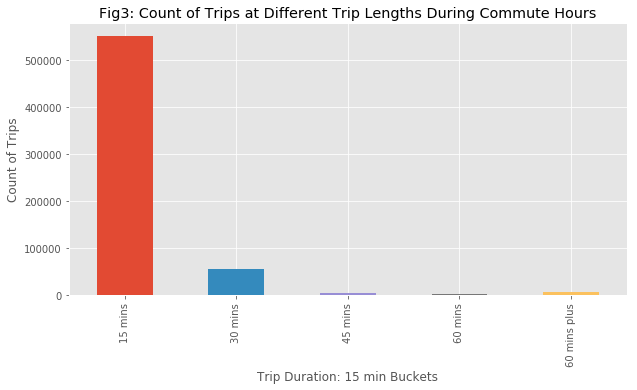

In [18]:
tbuckets = pd.read_csv('timebuckets.csv')
tbuckets.plot("time_range", "count", kind = "bar", legend = False, figsize=(10,5))
plt.xlabel("Trip Duration: 15 min Buckets")
plt.ylabel("Count of Trips")
plt.title("Fig3: Count of Trips at Different Trip Lengths During Commute Hours")

According to Fig3 shown above, a large majority of commuter trips last 15 minutes or less. This means that if Ford GoBike offered annual subscriptions at a cheaper price (maybe \$10 a month), for unlimited 20-minute rides, they can possibly increase ridership.

The second approach is to try and increase ridership outside of commuting hours. As we discovered above, customers who pay for one-way trips or day trips of unlimited 30-minute rides tend not to be riding during commuting hours. In fact, only around 30% of customer trips under these restrictions can be considered commuter trips. It would be interesting to see what the distribution of trips looks like for each hour of the day for only customers (excluding subscribers).

In [19]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT MIN(EXTRACT(HOUR FROM start_date)) as hour_num, COUNT (trip_ID) as count FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Customer" GROUP BY EXTRACT(HOUR FROM start_date) ORDER BY hour_num' > custbyhour.csv

Waiting on bqjob_r769b7f20d498e666_0000016412947324_1 ... (0s) Current status: DONE   

Query Code:
```SQL
bq query --use_legacy_sql=FALSE '
  SELECT MIN(EXTRACT(HOUR FROM start_date)) as hour_num, COUNT (trip_ID) as count
  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
  WHERE subscriber_type = "Customer"
  GROUP BY EXTRACT(HOUR FROM start_date)
  ORDER BY hour_num'
```

Text(0.5,1,'Fig4: Count of Trips at Each Hour of the Day for Customers Only')

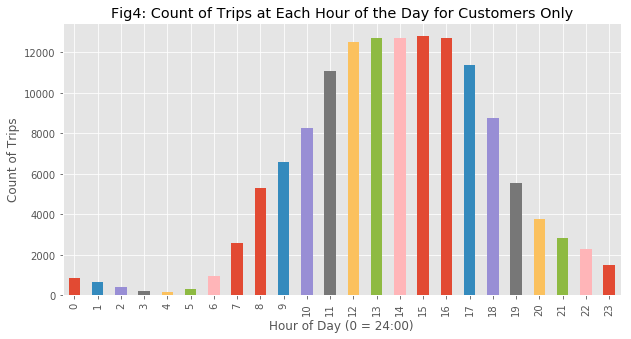

In [20]:
custbyhour = pd.read_csv('custbyhour.csv')
custbyhour.plot("hour_num", "count", kind = "bar", legend = False, figsize=(10,5))
plt.xlabel("Hour of Day (0 = 24:00)")
plt.ylabel("Count of Trips")
plt.title("Fig4: Count of Trips at Each Hour of the Day for Customers Only")

Fig4, as shown above, illustrates that throughout the week, customer trips peak between 10am and 6pm. This suggests that most of these customer trips are used for leisurely activities rather than to commute to and from work. According to Fig2 at the top of this report, most people are riding around noon on weekends. Fig2 also shows that there are people using these bikes on weekdays between the two commuting hour peaks. Therefore, it might be good to sometimes offer a discount to the flat rate for single trips taken around noon. This might attract tourists to take a bike ride during these hours. People who don't commute to work by bike, might also want to get lunch away from their office. Offering discounts around noon for single ride trips might be attractive to these people as well.

The only one day packages offered at the moment are unlimited 30-minute rides for \$10 a day. It would be interesting to see if there are other packages that can be offered.

In [21]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT t.time_range, COUNT(*) as count FROM(SELECT CASE WHEN duration_sec between 0 AND 900 THEN "15 mins" WHEN duration_sec between 900 AND 1800 THEN "30 mins" WHEN duration_sec between 1800 AND 2700 THEN "45 mins" WHEN duration_sec between 2700 AND 3600 THEN "60 mins" ELSE "60 mins plus" end as time_range FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE subscriber_type = "Customer") t GROUP BY t.time_range ORDER BY time_range' > custtimebuckets.csv

Waiting on bqjob_r2a4bf200d56d5e27_0000016412949609_1 ... (0s) Current status: DONE   

Query Code:
```SQL
bq query --use_legacy_sql=FALSE '
  SELECT t.time_range, COUNT(*) as count
  FROM(
    SELECT CASE
      WHEN duration_sec between 0 AND 900 THEN "15 mins"
      WHEN duration_sec between 900 AND 1800 THEN "30 mins"
      WHEN duration_sec between 1800 AND 2700 THEN "45 mins"
      WHEN duration_sec between 2700 AND 3600 THEN "60 mins"
      ELSE "60 mins plus" end as time_range
      FROM `bigquery-public-data.san_francisco.bikeshare_trips`
      WHERE subscriber_type = "Customer") t
  GROUP BY t.time_range
  ORDER BY time_range'
```

Text(0.5,1,'Fig5: Count of Trips at Different Trip Lengths for Customers Only')

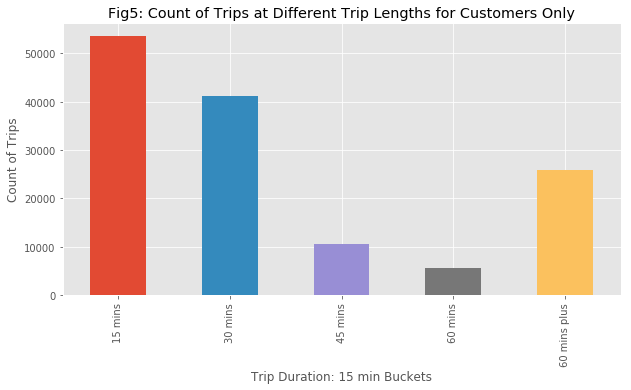

In [22]:
tbuckets2 = pd.read_csv('custtimebuckets.csv')
tbuckets2.plot("time_range", "count", kind = "bar", legend = False, figsize=(10,5))
plt.xlabel("Trip Duration: 15 min Buckets")
plt.ylabel("Count of Trips")
plt.title("Fig5: Count of Trips at Different Trip Lengths for Customers Only")

As shown in Fig5 above, there are actually a lot of trips being taken that are 15 minutes or less, and 60 minutes or more. Maybe different price packages can be offered for 15-minute trips and hour long trips. For example, we can offer \$5 for a day pass for unlimited 15-minute trips, or \$20 for a day pass for unlimited hour long trips. This might also increase ridership.